In [77]:
# ln -s ../code/analytic.py analytic.py
%matplotlib inline

import numpy as np
import pandas as pd
import math

import thinkstats2
import thinkplot

import nsfg
import nsfg2
import first

import copy
import random
import matplotlib.pyplot as pyplot




#import nsfg
#import first
#import brfss
#import scatter

## Classical hypothesis testing

The fundamental question we want to address is whether the effects we see in a sample are likely to appear in the larger population. There are several approaches including Fisher's null hypothesis testing, Neyman-Pearson decision theory, and Bayesian inference.
- Quantify the size of the apparent effect by choosing a **test statistic**.
- Define the **null hypothesis**, which is a model of the system based on the assumption that the apparent effect is not real.
- Compute a **p-value** which is the probability of seeing the apparent effect if the null hypothesis were true.
- Interpret the result: if the p-value is low, the effect is said to be **statistically significant**, unlikely to appear in the larger population.

## 9.2 Hypothesis Testing

In [78]:
# Leveraging provided class HypothesisTest

class CoinTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat

    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice('HT') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data

In [79]:
ct = CoinTest((140, 110))
pvalue = ct.PValue()
print(f'The p-value is: {pvalue:.3f}')

The p-value is: 0.076


## Testing difference in means

One way to model the null hypothesis is by **permutation**; we can take the values for both groups and shuffle them, trating the two groups as one big group.

In [80]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

`RunModel` simultated the null hypothesis by shuffling the pooled values and splitting them into two groups with sizes `n` and `m`.

In [81]:
live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
print(f'The p-value is: {pvalue:.3f}')


The p-value is: 0.177


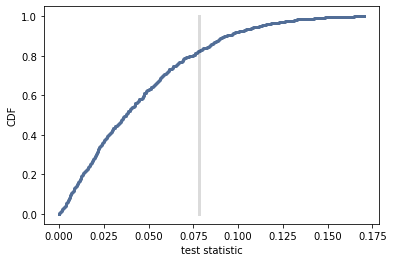

<Figure size 576x432 with 0 Axes>

In [82]:
ht.PlotCdf()
thinkplot.Show(xlabel='test statistic', ylabel='CDF')

In [83]:
data = firsts.totalwgt_lb.values, others.totalwgt_lb.values
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
print(f'The p-value is: {pvalue:.3f}')

The p-value is: 0.000


## Testing a correlation

In [84]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs,ys = data
        test_stat = abs(thinkstats2.Corr(xs,ys))
        return test_stat

    def RunModel(self):
        xs,ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [85]:
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
data = live.agepreg.values, live.totalwgt_lb.values
ht = CorrelationPermute(data)
pvalue = ht.PValue()
print(f'The p-value is: {pvalue:.3f}')

The p-value is: 0.000


## Testing proportions

In [86]:
class DiceTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        observed = data
        n=sum(observed)
        expected=np.ones(6) * n / 6
        test_stat = sum(abs(observed - expected))
        return test_stat

    def RunModel(self):
        n = sum(self.data)
        values = [1,2,3,4,5,6]
        rolls = np.random.choice(values, n, replace=True)
        hist = thinkstats2.Hist(rolls)
        freqs = hist.Freqs(values)
        return freqs

In [87]:
data = [8,9,19,5,8,11]
ht = DiceTest(data)
pvalue = ht.PValue()
print(f'The p-value is: {pvalue:.3f}')

The p-value is: 0.116


## Chi-squared tests

For testing proportions, it is common to us a chi-squared statistic
$$\chi^2=\sum_{i}\frac{(O_i-E_i)^2}{E_i}$$

In [88]:
class DiceChiTest(DiceTest):
    
    def TestStatistic(self, data):
        observed = data
        n=sum(observed)
        expected = np.ones(6)*n / 6
        test_stat = sum((observed-expected)**2/expected)
        return test_stat

In [89]:
ht = DiceChiTest(data)
pvalue = ht.PValue()
print(f'The p-value is: {pvalue:.3f}')

The p-value is: 0.034


In [97]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        first, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack(firsts, others)

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35,44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist=thinkstats2.Hist(lengths)
        observed=np.array(hist.Freqs(self.values))
        expected=self.expected_probs * len(lengths)
        stat=sum((observed-expected)**2 / expected)
        return stat

In [100]:
data = firsts.prglngth.values, others.prglngth.values

ht = PregLengthTest(data)
pvalue = ht.PValue()
print(f'The p-value is: {pvalue:.3f}')

TypeError: _vhstack_dispatcher() takes 1 positional argument but 2 were given

In [96]:
data

(array([39, 39, 38, ..., 39, 34, 39]), array([39, 39, 39, ..., 39, 39, 39]))